# Final Project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime


#SK-learn libraries for setup
from sklearn.model_selection import train_test_split

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#SK-learn libraries for transformation and pre-processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer



# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#Read data
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/data/")

#training data
train_data_full = pd.read_csv('train.csv')
train_data_full.head()

#testing data
test_data = pd.read_csv('test.csv')

In [19]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Prep

In [4]:
#Create a program age variable
#Do this before we do the train test split because the beginning of the program is a constant, so we don't
#have to worry about 'contaminating' any of our data by applying the same transformation to the entire dataset

#Convert to datetime object
train_data_full['datetime'] = train_data_full['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_data['datetime'] = test_data['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#Initialized program beginning
prog_beginning = '2011-01-01 00:00:00'

prog_beginning_conv = datetime.strptime(prog_beginning, '%Y-%m-%d %H:%M:%S')

#Create a program age variable
train_data_full['prog_age'] = train_data_full['datetime'] - prog_beginning_conv
test_data['prog_age'] = test_data['datetime'] - prog_beginning_conv


#convert the time delta to float of days
train_data_full['prog_age'] = train_data_full['prog_age'].dt.total_seconds() / (24 * 60 * 60)
test_data['prog_age'] = test_data['prog_age'].dt.total_seconds() / (24 * 60 * 60)


#create an hour variable in both the training and development data
train_data_full['hour'] = train_data_full.datetime.apply(lambda x : x.hour)
test_data['hour'] = test_data.datetime.apply(lambda x : x.hour)

In [5]:
#Split into train and development
train_data, dev_data = train_test_split(train_data_full, random_state = 0)

In [6]:
#Add a string desctriptor for weather
weather_values = [1,2,3,4]
weather_descriptions = ['Nice Weather', 'OK Weather', 'Poor Weather', 'Bad Weather']
weather_dict_df = pd.DataFrame({'weather' : weather_values, 'weather_descriptions': weather_descriptions})

weather_dict_df
train_data = pd.merge(train_data, weather_dict_df, how = 'left')

#Add a string descriptor for season
season_values = [1,2,3,4]
season_str = ['Spring', 'Summer', 'Fall', 'Winter']
season_dict_df = pd.DataFrame({'season' : season_values, 'season_str': season_str})

train_data = pd.merge(train_data, season_dict_df, how = 'left')

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour,weather_descriptions,season_str
0,2012-12-09 17:00:00,4,0,0,3,14.76,17.425,93,8.9981,20,209,229,708.708333,17,Poor Weather,Winter
1,2011-06-19 00:00:00,2,0,0,1,28.70,32.575,65,0.0000,18,71,89,169.000000,0,Nice Weather,Summer
2,2012-05-10 19:00:00,2,0,1,1,22.14,25.760,37,23.9994,84,469,553,495.791667,19,Nice Weather,Summer
3,2011-12-06 08:00:00,4,0,1,2,18.86,22.725,94,12.9980,13,401,414,339.333333,8,OK Weather,Winter
4,2011-04-17 08:00:00,2,0,0,1,15.58,19.695,46,26.0027,7,36,43,106.333333,8,Nice Weather,Summer


In [7]:
#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

    

## Feature Engineering / Preprocessing

In [8]:
#Create lists of categorical and numeric predictors
categorical_predictors = ['season', 'holiday', 'workingday', 'hour']
numerical_predictors = ['temp', 'atemp', 'humidity', 'windspeed', 'prog_age']

In [9]:
#Categorical variable imputer
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_df = X
        for col in self.cols:
            transformed_df.loc[:, col] = transformed_df.loc[:, col].astype(str)
        return transformed_df
       

In [10]:
#One-hot / hashing for categorical features
from sklearn.feature_extraction import FeatureHasher, DictVectorizer

class MyVectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorize a set of categorical variables
    """
    
    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):      
        #define the data
        data = X[self.cols]
        
        #select a vectorizer based on the hashing argument
        if self.hashing == None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features=self.hashing)
        
        #fit the vectorizer chosen based on columns specified
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )
   

In [11]:
#Numerical variable imputer
class MyNumericImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols, strategy = 'mean'):
        self.cols = cols
        self.strategy = strategy

    def fit(self, X, y=None):       
        self.imputer = Imputer(strategy = self.strategy)
        self.imputer.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.imputer.transform(X[self.cols]), columns = self.cols)
        #return self.imputer.transform(X[self.cols])


In [12]:
#Numeical variable scaler
class MyScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X[self.cols]), columns = self.cols)

In [13]:
#Categorical pipeline

#instantiate imputer and vectorizer for categorical pipe
imp_for_pipe = CategoricalImputer(categorical_predictors)
vect_for_pipe = MyVectorizer(cols = categorical_predictors, hashing = None)

#construct pipeline
categorical_pipe = Pipeline([
        ('to_string', imp_for_pipe),
        ('vectorize', vect_for_pipe)
    ])

In [14]:
#test categorical pipeline
transformed_train = categorical_pipe.fit_transform(train_data)

transformed_train.head()

,holiday=0,holiday=1,hour=0,hour=1,hour=10,hour=11,hour=12,hour=13,hour=14,hour=15,...,hour=6,hour=7,hour=8,hour=9,season=1,season=2,season=3,season=4,workingday=0,workingday=1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [15]:
#Numerical variables pipeline

#instantiate imputer for pipeline
mynumimp = MyNumericImputer(cols = numerical_predictors, strategy = 'mean')
#instantiate scaler for pipeline
scaler = MyScaler(cols = numerical_predictors)

#construct pipeline
numerical_pipe = Pipeline([
        ('impute', mynumimp),
        ('scale', scaler)
    ])

In [16]:
#test numerical pipeline
transformed_train_2 = numerical_pipe.fit_transform(train_data)

transformed_train_2.head()

,temp,atemp,humidity,windspeed,prog_age
0,-0.691508,-0.723967,1.619880,-0.464121,1.654910
1,1.101073,1.066229,0.164428,-1.553235,-0.902227
2,0.257505,0.260936,-1.291023,1.351609,0.646111
3,-0.164278,-0.097694,1.671860,0.020020,-0.095188
4,-0.586062,-0.455733,-0.823199,1.594085,-1.199141


In [17]:
#transform both the categorical and numeric features using FeatureUnion
fu = FeatureUnion([
        ('numerical', numerical_pipe),
        ('categorical', categorical_pipe)
    ])


#Training data
X_train_transformed = fu.fit_transform(train_data)
X_train_transformed_df = pd.DataFrame(X_train_transformed)

#Development data
X_dev_transformed = fu.transform(dev_data)
X_dev_transformed_df = pd.DataFrame(X_dev_transformed)

#test data
X_test_transformed = fu.transform(test_data)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#X_dev_transformed_df.head()
X_train_transformed_df.head()
#X_dev_transformed_df.shape
#dev_data.shape
#dev_data['prog_age']
#dev_data.prog_age
#train_data['prog_age']

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-0.691508,-0.723967,1.619880,-0.464121,1.654910,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.101073,1.066229,0.164428,-1.553235,-0.902227,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.257505,0.260936,-1.291023,1.351609,0.646111,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.164278,-0.097694,1.671860,0.020020,-0.095188,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.586062,-0.455733,-0.823199,1.594085,-1.199141,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Model  

Try fitting separate models for casual and registered, then add the results to get count.  

In v1.2 of this model, tried fitting a decision tree regressor, the results from which were not as promising as random forest regressors. The decision tree regressor section has been removed from this notebook in the interest of brevity.

### Random Forest Regressor

#### Predict Total Rentals Directly

In [18]:
#instantiate the regressor with the best parameters found from Gridsearch
rf = RandomForestRegressor(max_depth = 40, n_estimators = 200)

#fit the classifier for casual rentals
rf.fit(X_train_transformed_df, train_data['count'])

#predict the training data and testing data
preds_train = rf.predict(X_train_transformed_df)
preds_dev = rf.predict(X_dev_transformed_df)
preds_test = rf.predict(X_test_transformed_df)

#actual
actual_train = train_data['count']
actual_dev = dev_data['count']

#Get RMSE for train and de data
RMSE_train = get_RMSE(actual_values = actual_train, predicted_values = preds_train)
print "Train Data Root Mean Squared Error: " + str(RMSE_train)

RMSE_dev = get_RMSE(actual_values = actual_dev, predicted_values = preds_dev)
print "dev Data Root Mean Squared Error: " + str(RMSE_dev)


Train Data Root Mean Squared Error: 0.245632808103
dev Data Root Mean Squared Error: 0.470131373916


In v1.2 of this notebook, a gridsearch over the max depth and number of estimators found the best performing model had a max depth of 35 and 200 trees. This model does seem to overfit the training data, but the overfitting does not seem to get worse as the max depth is increased beyond 35 or so.

#### Error Analysis

In [21]:
#Predictions with the largest absolute error
train_errors = preds_train - np.array(actual_train)

#merge train errors with training data
train_errors_df = train_data
train_errors_df['raw_error'] = train_errors

train_errors_df['abs_error'] = abs(train_errors_df.raw_error)

#rank observations by absolute value of error
train_errors_df['abs_error_rank'] = train_errors_df.abs_error.rank(ascending = False)
train_errors_df['hour'] = train_errors_df.hour.astype(float)


#get the worst ~20% of errors
train_errors_df = train_errors_df.sort_values(by = 'abs_error_rank', axis = 0)
worst_errors = train_errors_df.loc[:1600,]
OK_predictions = train_errors_df.loc[1600:,]

worst_errors.describe()

,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour,raw_error,abs_error,abs_error_rank
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,1.707469,23.528216,27.190996,64.020747,14.124684,77.508299,274.493776,352.002075,453.391943,14.286307,-2.098998,56.858379,241.500000
std,0.822947,5.930402,6.386642,21.618301,8.368569,80.836588,178.948560,215.179657,179.050059,5.177612,61.143152,22.434427,139.285648
min,1.000000,8.200000,11.365000,0.000000,0.000000,0.000000,2.000000,2.000000,0.708333,0.000000,-163.385000,36.645000,1.000000
25%,1.000000,18.860000,22.725000,47.000000,8.998100,17.000000,122.000000,160.500000,324.218750,10.000000,-49.167500,41.191250,121.250000
50%,1.000000,24.600000,27.275000,65.000000,12.998000,50.000000,259.000000,350.500000,494.000000,16.000000,-37.742500,49.500000,241.500000
75%,2.000000,27.880000,31.630000,83.000000,19.001200,108.000000,368.000000,508.500000,594.697917,18.000000,51.495000,65.312500,361.750000
max,3.000000,39.360000,42.425000,100.000000,56.996900,367.000000,886.000000,977.000000,718.333333,23.000000,198.190000,198.190000,482.000000


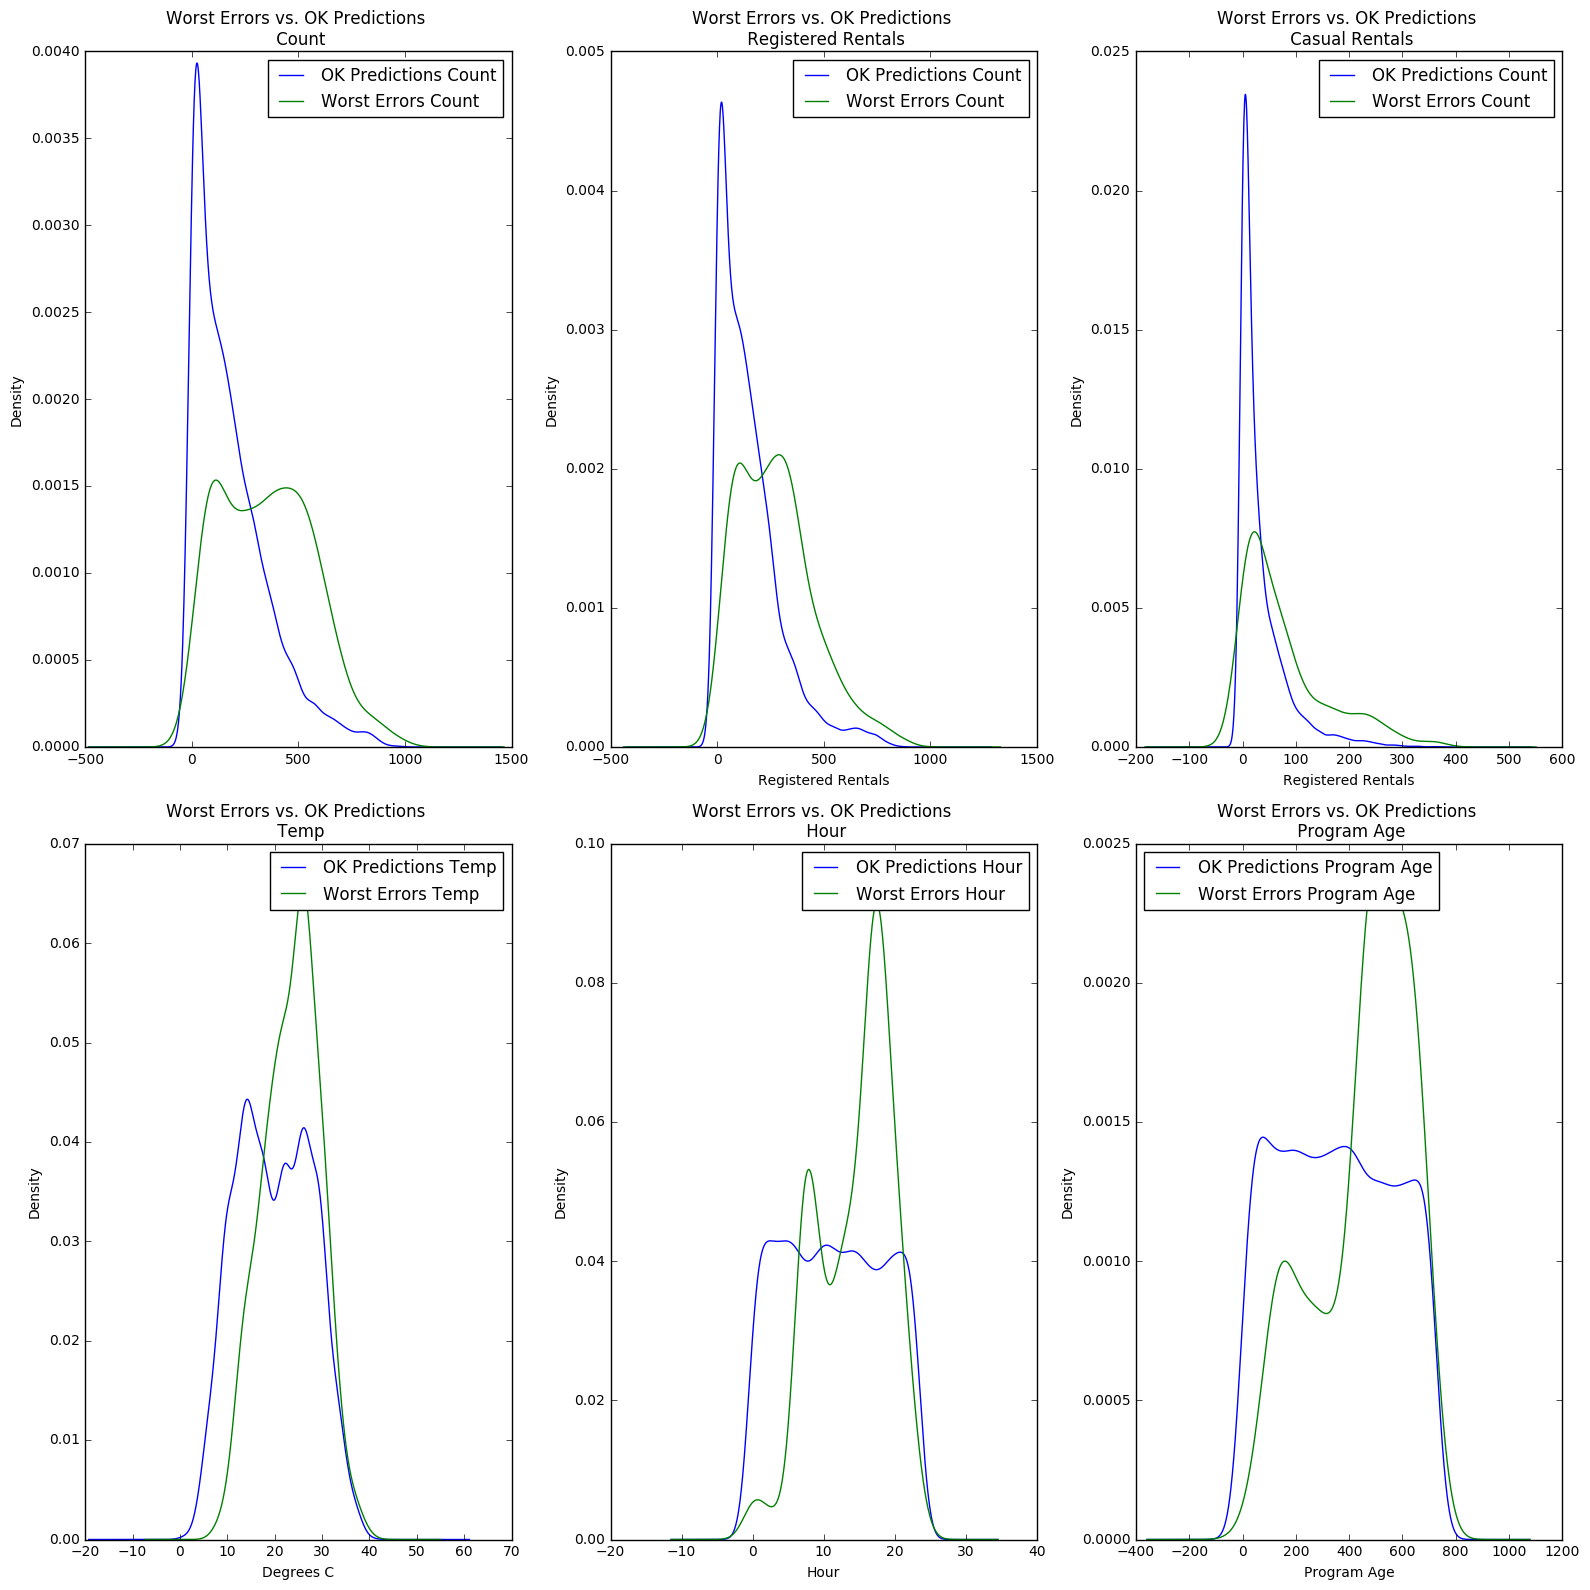

In [62]:
#Look at various features in the worst errors compared to the overall dataset

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize = (16,16))


#count
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,1)
plt.subplot(2,3,1)
OK_predictions['count'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['count'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.title('Worst Errors vs. OK Predictions \n Count')



#registered
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,2)
plt.subplot(2,3,2)
OK_predictions['registered'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['registered'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Registered Rentals')
plt.title('Worst Errors vs. OK Predictions \n Registered Rentals')


#casual
#The model seems to do pretty well with casual rentals - the distribution of casual rentals
#in the worst predictions and the ok predictions look similar
ax = fig.add_subplot(2,3,3)
plt.subplot(2,3,3)
OK_predictions['casual'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['casual'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Registered Rentals')
plt.title('Worst Errors vs. OK Predictions \n Casual Rentals')



#Temp
ax = fig.add_subplot(2,3,4)
plt.subplot(2,3,4)
OK_predictions['temp'].plot(kind = 'density', label = 'OK Predictions Temp')
worst_errors['temp'].plot(kind = 'density', label = 'Worst Errors Temp')
plt.legend(loc=1, ncol=1)
plt.xlabel('Degrees C')
plt.title('Worst Errors vs. OK Predictions \n Temp')


#Hour
ax = fig.add_subplot(2,3,5)
plt.subplot(2,3,5)
OK_predictions['hour'].plot(kind = 'density', label = 'OK Predictions Hour')
worst_errors['hour'].plot(kind = 'density', label = 'Worst Errors Hour')
plt.legend(loc=1, ncol=1)
plt.xlabel('Hour')
plt.title('Worst Errors vs. OK Predictions \n Hour')



#Program age
ax = fig.add_subplot(2,3,6)
plt.subplot(2,3,6)
OK_predictions['prog_age'].plot(kind = 'density', label = 'OK Predictions Program Age')
worst_errors['prog_age'].plot(kind = 'density', label = 'Worst Errors Program Age')
plt.legend(loc=2, ncol=1)
plt.xlabel('Program Age')
plt.title('Worst Errors vs. OK Predictions \n Program Age')


plt.tight_layout()
    
plt.show()




In [51]:
#export testing data results

#first change the working directory
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/NC_work/Output/")

#convert test predictions to DataFrame
preds_test_df = pd.DataFrame(preds_test, columns = ['count'])

#add column with datetime
preds_test_df['datetime'] = test_data['datetime']

#re-order columns
preds_test_df = preds_test_df[['datetime', 'count']]

#export to CSV
preds_test_df.to_csv('NC_submission_1.csv', index = False)

preds_test_df.head()

,datetime,count
0,2011-01-20 00:00:00,11.410
1,2011-01-20 01:00:00,6.450
2,2011-01-20 02:00:00,5.250
3,2011-01-20 03:00:00,4.750
4,2011-01-20 04:00:00,2.505
